In [1]:
import warnings  
warnings.filterwarnings("ignore")

In [211]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
import datetime
from sklearn.metrics import r2_score
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

In [8]:
train = pd.read_csv("data/train.csv")
train.Province_State.fillna("None", inplace=True)
display(train.head(5))
display(train.describe())

Id  County Province_State Country_Region  Population  Weight        Date  \
0   1     NaN           None    Afghanistan    2.77e+07    0.06  2020-01-23   
1   2     NaN           None    Afghanistan    2.77e+07    0.58  2020-01-23   
2   3     NaN           None    Afghanistan    2.77e+07    0.06  2020-01-24   
3   4     NaN           None    Afghanistan    2.77e+07    0.58  2020-01-24   
4   5     NaN           None    Afghanistan    2.77e+07    0.06  2020-01-25   

           Target  TargetValue  
0  ConfirmedCases          0.0  
1      Fatalities          0.0  
2  ConfirmedCases          0.0  
3      Fatalities          0.0  
4  ConfirmedCases          0.0

Id  County  Population    Weight  TargetValue
count  28007.00     0.0    2.80e+04  28006.00     28006.00
mean   14004.00     NaN    3.86e+07      0.35        63.95
std     8085.07     NaN    1.41e+08      0.30       770.71
min        1.00     NaN    3.59e+04      0.05      -209.00
25%     7002.50     NaN    2.14e+06      0.06         0.00
50%    14004.00     NaN    1.06e+07      0.29         0.00
75%    21005.50     NaN    3.79e+07      0.62         1.00
max    28007.00     NaN    1.40e+09      0.95     33274.00

In [29]:
China = train[train['Country_Region']=='China']
confirmed_China = China[China['Target']=='ConfirmedCases'][['Date','TargetValue']]
confirmed_China['Date'] = pd.to_datetime(confirmed_China['Date'])
confirmed_China = confirmed_China.groupby('Date').sum()

In [32]:
confirmed_China_cumsum = confirmed_China.cumsum()

In [45]:
x = (np.arange(len(confirmed_China))+1) / 7
y = np.array(confirmed_China_cumsum.TargetValue)

In [30]:
confirmed_China.head()

TargetValue
Date                   
2020-01-23        190.0
2020-01-24        554.0
2020-01-25        972.0
2020-01-26       1338.0
2020-01-27       1604.0

Text(0.5, 0, 'Date')

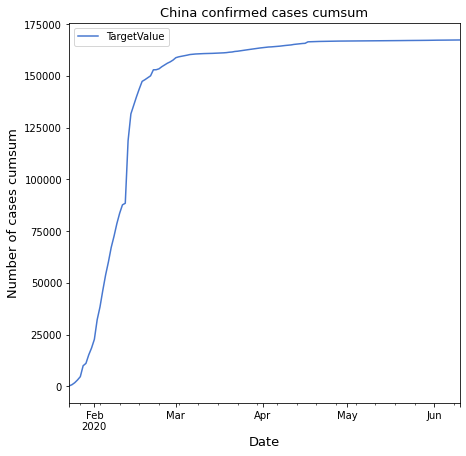

In [154]:
fig, ax1= plt.subplots(1, 1, figsize=(7,7))
confirmed_China_cumsum.plot(ax=ax1)
ax1.set_title("China confirmed cases cumsum", size=13)
ax1.set_ylabel("Number of cases cumsum", size=13)
ax1.set_xlabel("Date", size=13)

In [59]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',mu=1,sd=1)
    beta = pm.Normal('beta',mu=1,sd=1)
    t0 = pm.Normal('t0',mu=10,sd=10)
    
    sigma = pm.HalfCauchy('sigma',1)
    mu = pm.Deterministic('mu',(alpha / (1+np.exp(-beta *  (x - t0) ))))
    y_pred = pm.Normal('y_pred',mu = mu,sd = sigma ,observed = y *  0.000001)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(50000, step,start)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 44 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [87]:
pm.summary(trace[40000:])

mean    sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha    1.65e-01  0.00  1.64e-01  1.65e-01        0.0      0.0     941.0   
beta     1.49e+00  0.03  1.42e+00  1.55e+00        0.0      0.0    5307.0   
t0       2.60e+00  0.02  2.57e+00  2.63e+00        0.0      0.0    1121.0   
sigma    4.00e-03  0.00  3.00e-03  4.00e-03        0.0      0.0    4014.0   
mu[0]    4.00e-03  0.00  4.00e-03  5.00e-03        0.0      0.0    4812.0   
...           ...   ...       ...       ...        ...      ...       ...   
mu[135]  1.65e-01  0.00  1.64e-01  1.65e-01        0.0      0.0     941.0   
mu[136]  1.65e-01  0.00  1.64e-01  1.65e-01        0.0      0.0     941.0   
mu[137]  1.65e-01  0.00  1.64e-01  1.65e-01        0.0      0.0     941.0   
mu[138]  1.65e-01  0.00  1.64e-01  1.65e-01        0.0      0.0     941.0   
mu[139]  1.65e-01  0.00  1.64e-01  1.65e-01        0.0      0.0     941.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
alpha     941.0     916.0    1040.0   1.01  
beta     5307.0    5300.0    5943.0   1.00  
t0       1118.0    1119.0    1249.0   1.01  
sigma    4014.0    4027.0    4341.0   1.00  
mu[0]    4812.0    4777.0    6226.0   1.00  
...         ...       ...       ...    ...  
mu[135]   941.0     916.0    1040.0   1.01  
mu[136]   941.0     916.0    1040.0   1.01  
mu[137]   941.0     916.0    1040.0   1.01  
mu[138]   941.0     916.0    1040.0   1.01  
mu[139]   941.0     916.0    1040.0   1.01  

[144 rows x 11 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a3cec85d0>,
      dtype=object)

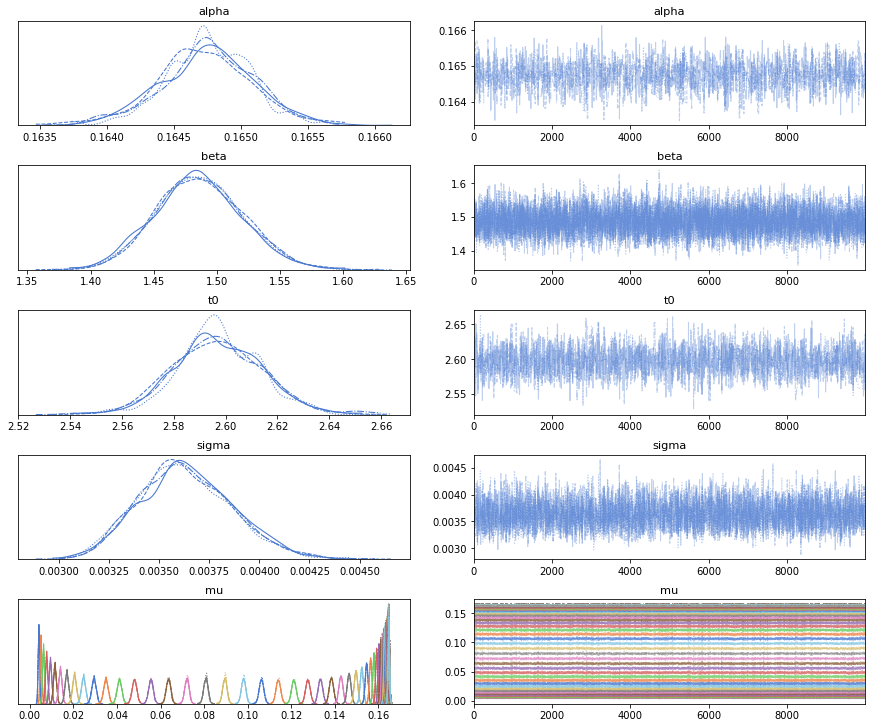

In [63]:
pm.traceplot(trace[40000:])

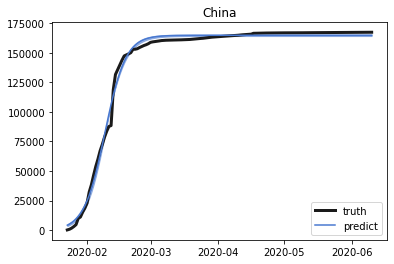

In [147]:
alpha = trace['alpha'].mean()
beta = trace['beta'].mean()
t0 = trace['t0'].mean()

alpha_hpd = pm.hpd(trace['alpha'])
beta_hpd = pm.hpd(trace['beta'])
t0_hpd = pm.hpd(trace['t0'])

y_pre_ = alpha / (1+np.exp(-beta *  (x - t0) )) * 1000000
y_pre_5 = alpha_hpd[0] / (1+np.exp(-beta_hpd[0] *  (x - t0_hpd[0]) )) * 1000000
y_pre_95 = alpha_hpd[1] / (1+np.exp(-beta_hpd[1] *  (x - t0_hpd[1]) )) * 1000000

plt.plot(confirmed_China_cumsum.index, confirmed_China_cumsum['TargetValue'], color='k', lw=3,label='truth');
plt.plot(confirmed_China_cumsum.index, y_pre_,  color='b',label='predict')
plt.title('China')
plt.legend()
plt.fill_between(confirmed_China_cumsum.index, y_pre_5, y_pre_95, color='b', alpha=0.5)

---
# 另外19个国家

In [219]:
data2 = pd.read_csv('data/time_series_covid19_confirmed_global.csv')
data2 = data2.groupby('Country/Region').sum().iloc[:,2:-2].T
data2.index = pd.to_datetime(data2.index)

In [220]:
data2.head()

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22                0        0        0        0       0   
2020-01-23                0        0        0        0       0   
2020-01-24                0        0        0        0       0   
2020-01-25                0        0        0        0       0   
2020-01-26                0        0        0        0       0   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                        0          0        0          0        0   
2020-01-23                        0          0        0          0        0   
2020-01-24                        0          0        0          0        0   
2020-01-25                        0          0        0          0        0   
2020-01-26                        0          0        0          4        0   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...               0        0           0          0        0   
2020-01-23      ...               0        0           0          0        2   
2020-01-24      ...               0        0           0          0        2   
2020-01-25      ...               0        0           0          0        2   
2020-01-26      ...               0        0           0          0        2   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                       0               0      0       0         0  
2020-01-23                       0               0      0       0         0  
2020-01-24                       0               0      0       0         0  
2020-01-25                       0               0      0       0         0  
2020-01-26                       0               0      0       0         0  

[5 rows x 188 columns]

In [221]:
country_20 = ['China','US','United Kingdom','Germany','Canada','France','South Africa','Korea, South','Italy','Australia','Afghanistan','Finland','Panama','Japan','Libya','Guinea-Bissau','Dominican Republic','Grenada','Turkey','Maldives']

In [222]:
country_20 = data2[country_20]

In [223]:
country_20.cumsum()

Country/Region     China        US  United Kingdom   Germany   Canada  \
2020-01-22           548         1               0         0        0   
2020-01-23          1191         2               0         0        0   
2020-01-24          2111         4               0         0        0   
2020-01-25          3517         6               0         0        0   
2020-01-26          5592        11               0         0        1   
...                  ...       ...             ...       ...      ...   
2020-06-10      10134021  85156722        13363775  11810825  4313367   
2020-06-11      10218237  87180312        13656635  11997516  4412526   
2020-06-12      10302465  89229298        13951037  12184742  4512121   
2020-06-13      10386751  91303824        14246865  12372009  4612164   
2020-06-14      10471086  93397882        14544207  12559527  4712568   

Country/Region    France  South Africa  Korea, South     Italy  Australia  \
2020-01-22             0             0             1         0          0   
2020-01-23             0             0             2         0          0   
2020-01-24             2             0             4         0          0   
2020-01-25             5             0             6         0          0   
2020-01-26             8             0             9         0          4   
...                  ...           ...           ...       ...        ...   
2020-06-10      11588263       1041060       1032910  15402620     514518   
2020-06-11      11780756       1099628       1044913  15638762     521807   
2020-06-12      11973976       1161555       1056964  15875067     529101   
2020-06-13      12167722       1227291       1069049  16111718     536421   
2020-06-14      12361875       1297329       1081170  16348707     543756   

Country/Region  Afghanistan  Finland  Panama    Japan  Libya  Guinea-Bissau  \
2020-01-22                0        0       0        2      0              0   
2020-01-23                0        0       0        4      0              0   
2020-01-24                0        0       0        6      0              0   
2020-01-25                0        0       0        8      0              0   
2020-01-26                0        0       0       12      0              0   
...                     ...      ...     ...      ...    ...            ...   
2020-06-10           445077   373053  574217   948482   6128          42091   
2020-06-11           467967   380117  592803   965669   6521          43480   
2020-06-12           491513   387190  612014   982919   6930          44940   
2020-06-13           515615   394277  632073  1000212   7348          46400   
2020-06-14           540381   401381  653491  1017581   7802          47860   

Country/Region  Dominican Republic  Grenada   Turkey  Maldives  
2020-01-22                       0        0        0         0  
2020-01-23                       0        0        0         0  
2020-01-24                       0        0        0         0  
2020-01-25                       0        0        0         0  
2020-01-26                       0        0        0         0  
...                            ...      ...      ...       ...  
2020-06-10                  689008     1385  8366809     54381  
2020-06-11                  710445     1408  8540832     56357  
2020-06-12                  732453     1431  8716050     58360  
2020-06-13                  755025     1454  8892727     60373  
2020-06-14                  777987     1477  9070966     62408  

[145 rows x 20 columns]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


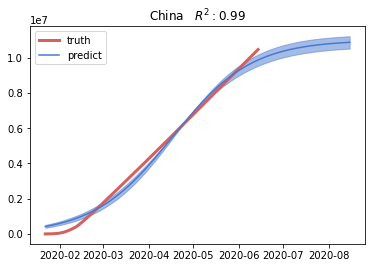

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


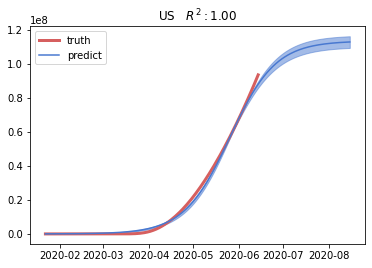

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


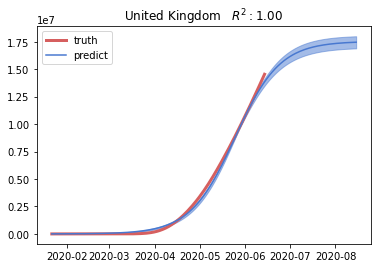

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


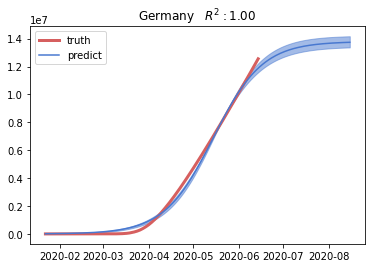

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


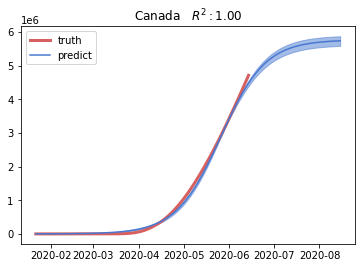

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


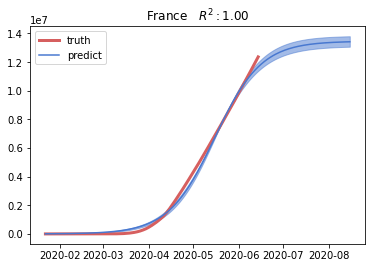

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


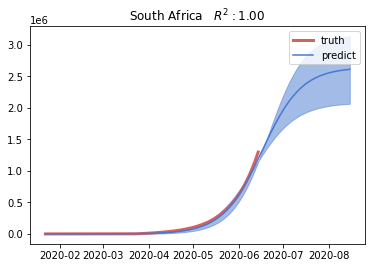

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


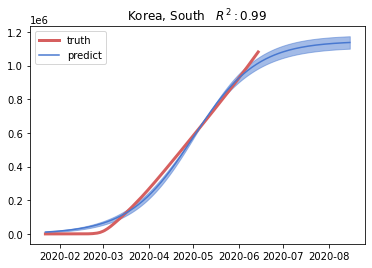

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


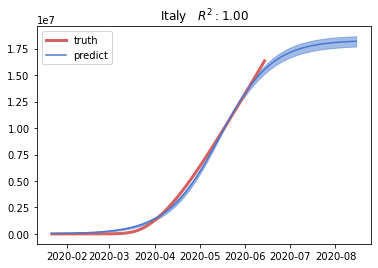

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


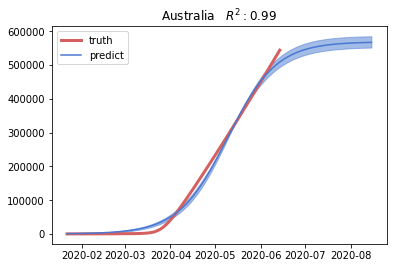

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


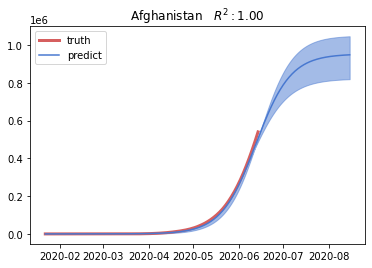

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


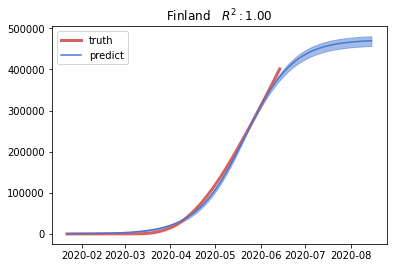

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


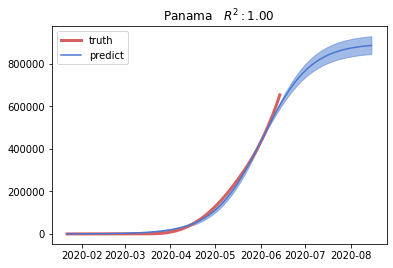

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


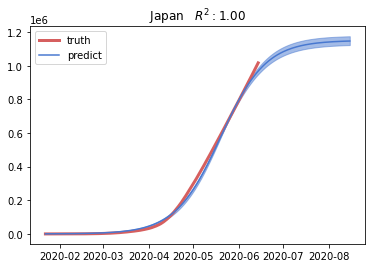

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


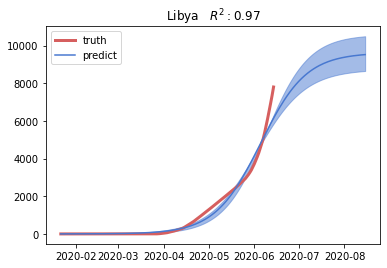

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


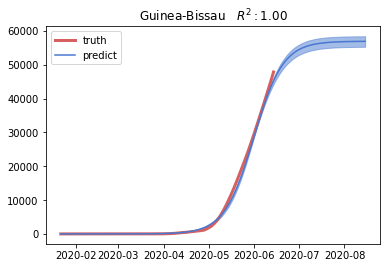

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


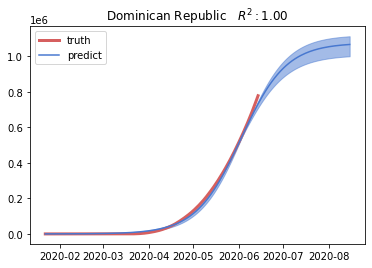

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


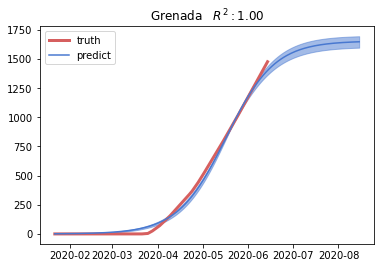

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


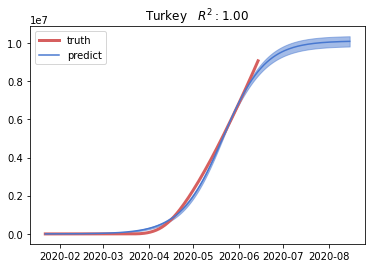

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [t0]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


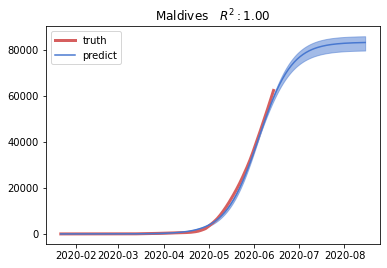

In [226]:
for country in country_20.columns:
    confirmed_country_cumsum = country_20[country].cumsum()
    reduce = len(str(confirmed_country_cumsum[-1])) - 1     
    
    x = (np.arange(len(confirmed_country_cumsum))+1) / 7
    y = np.array(confirmed_country_cumsum)

    with pm.Model() as model:
        alpha = pm.Normal('alpha',mu=0.165,sd=1)
        beta = pm.Normal('beta',mu=1.49,sd=1)
        t0 = pm.Normal('t0',mu=2.6,sd=5)

        sigma = pm.Normal('sigma',mu=0.1,sd=0.1)
        mu = pm.Deterministic('mu',(alpha / (1+np.exp(-beta *  (x - t0) ))))
        y_pred = pm.Normal('y_pred',mu = mu,sd = sigma ,observed = y  / (10 ** reduce) )

        start = pm.find_MAP()
        step = pm.Metropolis()
        
        trace = pm.sample(5000, step,start)
        
    alpha = trace['alpha'].mean()
    beta = trace['beta'].mean()
    t0 = trace['t0'].mean()

    alpha_hpd = pm.hpd(trace['alpha'])
    beta_hpd = pm.hpd(trace['beta'])
    t0_hpd = pm.hpd(trace['t0'])
    
    df_res = confirmed_country_cumsum.copy()
    df_res = pd.DataFrame(df_res)
    maxdate = np.max(df_res.index)
    df_res = df_res.reset_index()
    for i in np.arange(1,62+1):
        df_res=df_res.append(pd.DataFrame({'index': [maxdate+datetime.timedelta(days=int(i))]}))
    df_res = df_res.set_index('index')
    
    y_pre = alpha / (1+np.exp(-beta *  (x - t0) )) * (10 ** reduce)
    
    x = np.arange(len(df_res) ) / 7

    y_pre_ = alpha / (1+np.exp(-beta *  (x - t0) )) * (10 ** reduce)
    y_pre_5 = alpha_hpd[0] / (1+np.exp(-beta_hpd[0] *  (x - t0_hpd[0]) )) * (10 ** reduce)
    y_pre_95 = alpha_hpd[1] / (1+np.exp(-beta_hpd[1] *  (x - t0_hpd[1]) )) * (10 ** reduce)

    plt.plot(confirmed_country_cumsum.index, confirmed_country_cumsum, color='r', lw=3,label='truth')
    plt.plot(df_res.index, y_pre_,  color='b',label='predict')   
    plt.title(country + "   $R^2:{:.2f}$".format(float(r2_score(y_pre,confirmed_country_cumsum))))
    plt.legend()
    plt.fill_between(df_res.index, y_pre_5, y_pre_95, color='b', alpha=0.5)
    plt.show()
